In [1]:
import matplotlib.pyplot as plt
%matplotlib inline
import pandas as pd
import os
from itertools import product
import numpy as np
import re

In [2]:
from min_bisection import solution_schema

In [3]:
root_fldr = 'runs\\v0.5'

In [4]:
def subdir_paths(folder):
    return [os.path.join(folder, f) for f in next(os.walk(folder))[1] if f != 'profiles']

meta_dfs = []
run_dfs = []
fldrs = subdir_paths(root_fldr)
for fldr in fldrs:
    print(fldr)
    sub_fldrs = subdir_paths(fldr)
    for sub_fldr in sub_fldrs:
        data_fldrs = subdir_paths(sub_fldr)
        for data_fldr in data_fldrs:
            meta_df = pd.read_csv(os.path.join(data_fldr, 'summary_stats.csv'))
            run_df = pd.read_csv(os.path.join(data_fldr, 'run_stats.csv'))
            for df in [meta_df, run_df]:
                if fldr.endswith('remove_once_again'):
                        df['act_tol'] = .0001
                        df['removal_method'] = 'dual_0_once'
                if fldr.endswith('test_tol'):
                        df['remove_constraints'] = ~pd.isnull(df['act_tol'])
                        df['removal_method'] = 'slack_0'
            meta_dfs.append(meta_df)
            run_dfs.append(run_df)
            
for key, df_list in {'summary': meta_dfs, 'run': run_dfs}.items():
    df = pd.concat(df_list)
    df['threshold_proportion'] = df['threshold_proportion'].fillna(0)
    df['act_tol'] = df['act_tol'].fillna(0)
    df.to_csv(os.path.join(root_fldr, f'{key}_stats.csv'), index=False)
    
meta = pd.read_csv(os.path.join(root_fldr, 'summary_stats.csv'))
run = pd.read_csv(os.path.join(root_fldr, 'run_stats.csv'))

runs\v0.5\remove_once_again
runs\v0.5\test_tol


In [5]:
meta.head()

,solve_id,solve_type,method,warm_start,min_search_proportion,threshold_proportion,remove_constraints,n,p,q,cut_type,cut_value,max_variables,max_constraints,total_cpu_time,gurobi_cpu_time,non_gurobi_cpu_time,objective_value,act_tol,removal_method
0,0,iterative,auto,warm,1,0.0,True,100,0.5,0.2,fixed,1000,4950,4874,438.422592,371.757843,66.664749,473.0,0.0001,dual_0_once
1,1,iterative,auto,warm,1,0.0,True,100,0.5,0.2,fixed,1000,4950,5372,635.315959,551.556763,83.759197,462.0,0.0001,dual_0_once
2,10,iterative,auto,warm,1,0.0,True,100,0.5,0.2,fixed,1000,4950,5054,771.444097,692.049432,79.394666,504.0,0.0001,dual_0_once
3,11,iterative,auto,warm,1,0.0,True,100,0.5,0.2,fixed,1000,4950,4881,585.693688,510.316425,75.377264,477.0,0.0001,dual_0_once
4,12,iterative,auto,warm,1,0.0,True,100,0.5,0.2,fixed,1000,4950,5499,811.799453,728.458974,83.340479,493.0,0.0001,dual_0_once


In [6]:
run.head()

,solve_id,solve_type,method,warm_start,min_search_proportion,threshold_proportion,remove_constraints,sub_solve_id,n,p,...,cuts_sought,cuts_added,cuts_removed,search_proportion_used,current_threshold,variables,constraints,cpu_time,act_tol,removal_method
0,0,iterative,auto,warm,1,0.0,True,0,100,0.5,...,100,100,0.0,1,NaN,4950,101,0.010156,0.0001,dual_0_once
1,0,iterative,auto,warm,1,0.0,True,1,100,0.5,...,1000,1000,100.0,1,NaN,4950,1001,0.039473,0.0001,dual_0_once
2,0,iterative,auto,warm,1,0.0,True,2,100,0.5,...,1000,1000,1000.0,1,NaN,4950,1001,0.033551,0.0001,dual_0_once
3,0,iterative,auto,warm,1,0.0,True,3,100,0.5,...,1000,1000,1000.0,1,NaN,4950,1001,0.032668,0.0001,dual_0_once
4,0,iterative,auto,warm,1,0.0,True,4,100,0.5,...,1000,1000,557.0,1,NaN,4950,1444,0.053031,0.0001,dual_0_once


In [7]:
def cpu_time_graph(time_measure, ignored_patterns, accepted_patterns, line_style, max_n):
    col_selection = time_measure if time_measure != 'proportion_cpu_time_gurobi' else ['total_cpu_time', 'gurobi_cpu_time']
    # average the runs
    gd = meta.groupby(['p', 'q', 'act_tol', 'removal_method', 'n'])[col_selection].mean().reset_index()
    gd['idx'] = gd['act_tol'].astype(str) + '_' + gd['removal_method'].astype(str)

    # filter graph data by data set
    filters = {idx: gd['idx'] == idx for idx in gd['idx'].unique()}

    # graph for each p, q combination 
    for (p, q) in product(gd['p'].unique(), gd['q'].unique()):
        for name, fltr in filters.items():
            # filter out ignored patterns and those not in accepted patterns
            if any([ip in name for ip in ignored_patterns]) or (accepted_patterns and all([ap not in name for ap in accepted_patterns])):
                continue
            subset = gd.loc[(gd['p'] == p) & (gd['q'] == q) & fltr & (gd['n'] <= max_n)].sort_values('n')
            # assign line style to group
            match = re.search('iterative_(.*)_.*_.*_.*', name).group(1) if re.search('iterative_(.*)_.*_.*_.*', name) \
                else 'no_match'
            style = line_style.get(match, '-')
            if isinstance(col_selection, list):
                plt.plot(subset['n'], subset[col_selection[1]]/subset[col_selection[0]], linestyle=style, label=name)
                plt.ylabel('proportion_of_cpu_time')
            else:
                plt.plot(subset['n'], subset[col_selection], linestyle=style, label=name)
                plt.ylabel('cpu_time')

        plt.title(f'{time_measure} comparison for p={p}, q={q}')
        plt.xlabel('n')
        plt.legend()
        plt.rcParams['figure.figsize'] = [8, 8]
        plt.show()

## Settings

In [8]:
# ignored_patterns = ['10_',
#                     '100_',
# #                     '1000_',
#                     '10000',
#                     '100000_',
#                     '1000000_']
# accepted_patterns = []

ignored_patterns = ['1e-05', '.001', '.01', '.05', '.075', '.1', '.125']
accepted_patterns = []

line_style = {
    '10': '--',
    '100': '-.',
    '1000': '--',
    '10000': '-.',
    '100000': '--',
    '1000000': '-.'
}
max_n = 150

## Total CPU Time

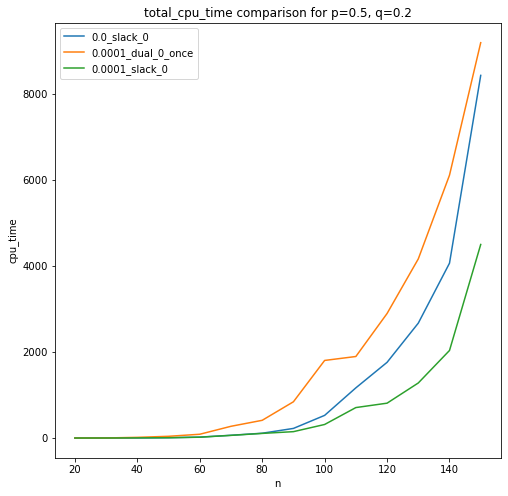

In [11]:
time_measure = 'total_cpu_time'
cpu_time_graph(time_measure, ignored_patterns, accepted_patterns, line_style, max_n)

## Gurobi CPU Time

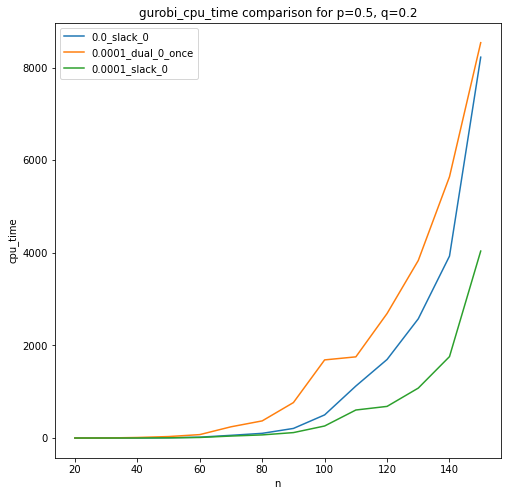

In [10]:
time_measure = 'gurobi_cpu_time'
cpu_time_graph(time_measure, ignored_patterns, accepted_patterns, line_style, max_n)

## Proportion CPU Time Gurobi

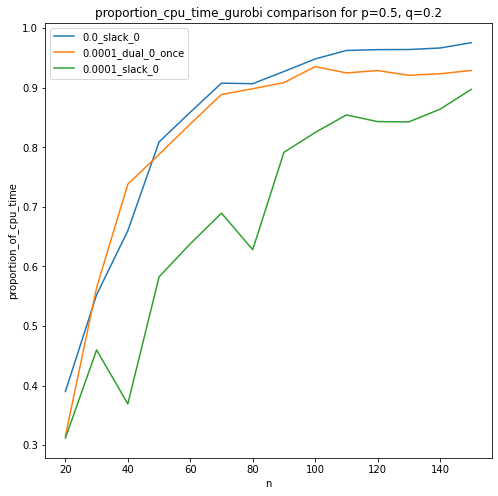

In [12]:
time_measure = 'proportion_cpu_time_gurobi'
cpu_time_graph(time_measure, ignored_patterns, accepted_patterns, line_style, max_n)

## Number of Max Constraints

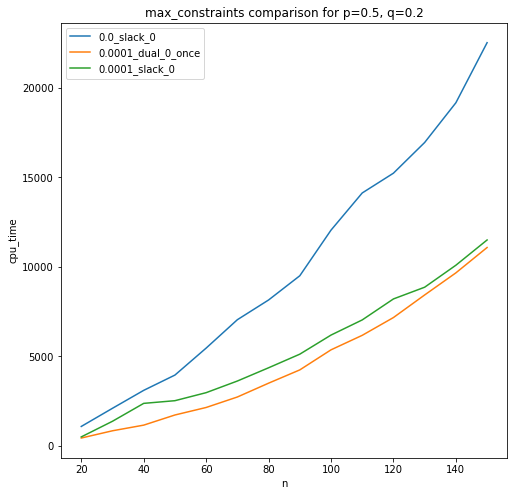

In [13]:
time_measure = 'max_constraints'
cpu_time_graph(time_measure, ignored_patterns, accepted_patterns, line_style, max_n)

## Number of LP's per Solve

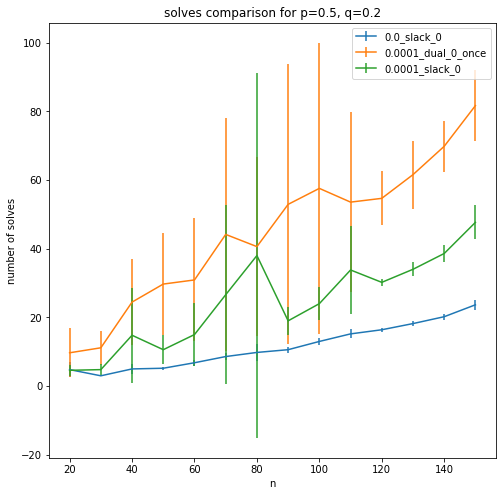

In [34]:
# Get number of runs from each solve
gd = run.groupby(['p', 'q', 'solve_id', 'act_tol', 'removal_method', 'n'])['sub_solve_id'].max().reset_index()

# rename and adjust for 0 indexing
gd.rename(columns={'sub_solve_id': 'solves'}, inplace=True)
gd['solves'] += 1

# get average and std for each unique run combination
gd = gd.groupby(['p', 'q', 'act_tol', 'removal_method', 'n'], as_index=False).agg({'solves': ['mean','std']})
gd.columns = [f'{i}_{j}' if j else i for i, j in gd.columns]

# create id
gd['idx'] = gd['act_tol'].astype(str) + '_' + gd['removal_method'].astype(str)

# filter graph data by data set
filters = {idx: gd['idx'] == idx for idx in gd['idx'].unique()}

# graph for each p, q combination 
for (p, q) in product(gd['p'].unique(), gd['q'].unique()):
    for name, fltr in filters.items():
        if any([ip in name for ip in ignored_patterns]) or (accepted_patterns and all([ap not in name for ap in accepted_patterns])):
            continue
        subset = gd.loc[(gd['p'] == p) & (gd['q'] == q) & fltr & (gd['n'] <= max_n)].sort_values('n')
        # assign line style to group
        match = re.search('iterative_(.*)_.*_.*_.*', name).group(1) if re.search('iterative_(.*)_.*_.*_.*', name) \
            else 'no_match'
        style = line_style.get(match, '-')
        plt.errorbar(subset['n'], subset['solves_mean'], subset['solves_std'], linestyle=style, label=name)

    plt.title(f'solves comparison for p={p}, q={q}')
    plt.ylabel('number of solves')
    plt.xlabel('n')
    plt.legend()
    plt.show()